# 6 курс, 4 неделя, Прогнозирование большого количества рядов

In [1]:
import pandas as pd
import numpy as np
import scipy as sc
import glob
import os

from scipy import stats
from scipy.spatial.distance import cdist

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from sklearn import metrics

from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering

import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Инструкция

Процесс подбора модели ARIMA в Питоне достаточно трудоёмок, поэтому вы не сможете вручную подобрать модель для каждого из рядов в выбранных ячейках. Чтобы облегчить ручной перебор, вам предстоит кластеризовать временные ряды и подобрать гиперпараметры модели ARIMA только один раз для всех рядов каждого кластера.

Результатом этой недели будут построенные с помощью ARIMA почасовые прогнозы количества поездок для всех географических зон Нью-Йорка. Модель, которую мы строим, должна делать почасовые прогнозы для всех выбранных непустых ячеек на 6 часов вперёд. Качество модели мы будем оценивать с помощью среднего абсолютного отклонения от истинного количества поездок в июне:

Qjune=1R∗715∗6∑r=1R∑T=2016.05.3123:002016.06.3017:00∑i=16∣∣y^rT|T+i−yrT+i∣∣.

R — количество прогнозируемых рядов, 715 — количество перебираемых концов истории.

Построенные прогнозы вам предстоит загрузить на kaggle. К сожалению, в формате kaggle сложно организовать конкурс по прогнозированию временных рядов в традиционном виде, с отложенным тестом и пересчётом лидерборда, поскольку прогнозы необходимо строить со скользящим концом истории. Но цель использования kaggle в этом проекте — не победа в конкурсе; вы всегда можете загрузить истинные данные за июнь и получить первое место. Цель в том, чтобы посмотреть, какие модели, решения и признаки использовали ваши коллеги, и понять, какие из них стоит попробовать и вам.



Чтобы сдать задание, выполните следующую последовательность действий.

__1. Составьте из данных о поездках прямоугольную таблицу так, чтобы по строкам было время, а по столбцам идентификатор ячейки (возьмите только те, которые были отобраны на второй неделе). Не используйте данные за последние имеющиеся месяцы — май и июнь 2016!__

In [2]:
glob.glob('D:/Obuchenie/!Data_sience/Home works/diplom_yellow_taxi/in/agreggate*.csv')

[]

In [3]:
def get_merged_csv(flist, **kwargs):
    return pd.concat([pd.read_csv(f, **kwargs) for f in flist], axis=1) #добавление столбцов axis=1

In [4]:
path = 'D:/Obuchenie/!Data_sience/Home works/diplom_yellow_taxi/'
fmask = os.path.join(path, '*aggregate*.csv')

raw_data = get_merged_csv(glob.glob(fmask), index_col=0)
print raw_data.shape

(2500, 21887)


In [6]:
data = raw_data.loc[:, '2014010100':'2016043023'].T
data.shape

(20423, 2500)

In [7]:
data['datetime'] = data.index
data['datetime']  = data['datetime'].apply(pd.to_datetime, format  = '%Y%m%d%H')
data.set_index(data.datetime, inplace=True)
data.drop('datetime', axis=1, inplace=True)

In [8]:
data.tail()

,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
datetime,,,,,,,,,,,,,,,,,,,,,
2016-04-30 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-04-30 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-04-30 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-04-30 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-04-30 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


__2. Перед проведением кластеризации стандартизуйте столбцы (вычтите выборочное среднее и поделите на выборочную дисперсию - __выборочное стандартное отклонение__). Это необходимо, поскольку при выборе модели ARIMA имеет значение только форма ряда, но не его средний уровень и размах колебаний.__

In [9]:
data_norm = data-data.mean(axis=0)/(data.std(axis=0, ddof=1))
data_norm.fillna('0', inplace=True)

In [10]:
data_norm.head()

,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
datetime,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,0,-0.009896,-0.009896,0,0,-0.006997,-0.006997,0,0,-0.013225,...,-0.015378,-0.022225,-0.023096,-0.013996,-0.006997,-0.006997,-0.008851,0,0,0
2014-01-01 01:00:00,0,-0.009896,-0.009896,0,0,-0.006997,-0.006997,0,0,-0.013225,...,-0.015378,-0.022225,-0.023096,-0.013996,-0.006997,-0.006997,-0.008851,0,0,0
2014-01-01 02:00:00,0,-0.009896,-0.009896,0,0,-0.006997,-0.006997,0,0,-0.013225,...,-0.015378,-0.022225,-0.023096,-0.013996,-0.006997,-0.006997,-0.008851,0,0,0
2014-01-01 03:00:00,0,-0.009896,-0.009896,0,0,-0.006997,-0.006997,0,0,-0.013225,...,-0.015378,-0.022225,-0.023096,-0.013996,-0.006997,-0.006997,-0.008851,0,0,0
2014-01-01 04:00:00,0,-0.009896,-0.009896,0,0,-0.006997,-0.006997,0,0,-0.013225,...,-0.015378,-0.022225,-0.023096,-0.013996,-0.006997,-0.006997,-0.008851,0,0,0


In [10]:
data_norm.mean(axis=0).mean()

6.694587301798424

__3. Кластеризуйте географические зоны по значениям стандартизованных рядов. Подберите число кластеров так, чтобы оно было не слишком большим, но ряды внутри кластеров имели похожую форму. Постройте графики стандартизованных рядов каждого кластера, чтобы в этом убедиться.__

In [28]:
%%time
inertia = []
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(data_norm.T)
    inertia.append(np.sqrt(kmeans.inertia_))

Wall time: 5min 12s


In [29]:
score = []
for i in range(1,8):
    score.append((inertia[i] - inertia[i+1])/(inertia[i-1] - inertia[i]))
    print 'k={}: D(k)={}'.format(i+1, round(score[i-1],3))

k=2: D(k)=0.509
k=3: D(k)=0.648
k=4: D(k)=0.68
k=5: D(k)=0.723
k=6: D(k)=0.78
k=7: D(k)=0.92
k=8: D(k)=0.759


 Минимальная инерция при k=2. Но 2 кластера - это маловато для самой сути задания. Давайте посмотрим на параметр Силуэта и выберем количество кластеров. 

Kmeans показал лучший показатель ситуэта. попробуем подобрать количество кластеров чтообы максимизировать значение коэффициента силуэта. 

In [11]:
%%time
siluet = []
for k in range(2,10):
        algoritms1 = KMeans(n_clusters=k, random_state=1)
        algoritms1.fit(data_norm.T)
        labels1 = algoritms1.labels_
        metric1 =  metrics.silhouette_score(data_norm.T, labels1)
        algoritms2 = AgglomerativeClustering(n_clusters=k)
        algoritms2.fit(data_norm.T)
        labels2 = algoritms2.labels_
        metric2 =  metrics.silhouette_score(data_norm.T, labels2)
        siluet.append([k, metric1, metric2])
sil_result = pd.DataFrame.from_records(siluet)
sil_result.columns = ['k', 'siluet_kmeans', 'siluet_AgglomerativeClustering']

Wall time: 21min 42s


In [12]:
sil_result.head()

,k,siluet_kmeans,siluet_AgglomerativeClustering
0,2,0.985713,0.985220
1,3,0.982584,0.982055
2,4,0.978763,0.975367
3,5,0.978997,0.975391
4,6,0.979327,0.975386


При все к показатели силуэта достаточно высоки, остановимся из разумности на k=3, и методе kmeans. 

In [15]:
%%time
algo = KMeans(n_clusters=3).fit(data_norm.T)
prediction = algo.fit_predict(data_norm.T)
labels = algo.labels_
centers = algo.cluster_centers_ 

Wall time: 1min 17s


In [16]:
print len(labels), len(centers), len(prediction)
print prediction

2500 3 2500
[0 0 0 ..., 0 0 0]


In [17]:
clusters = pd.DataFrame([labels], columns = data_norm.columns).T
clusters.columns = ['cluster']
clusters.head()

,cluster
1,0
2,0
3,0
4,0
5,0


In [18]:
clusters['cluster'].value_counts()

0    2466
2      24
1      10
Name: cluster, dtype: int64

In [19]:
print centers

[[    2.28649774     3.51277512     3.57360237 ...,     1.05575971
      1.12104762     1.30271834]
 [ 1022.93690036   919.43690036   807.73690036 ...,   893.43690036
    986.43690036   965.33690036]
 [  589.42994699   618.97161365   538.59661365 ...,   456.92994699
    500.09661365   530.88828032]]


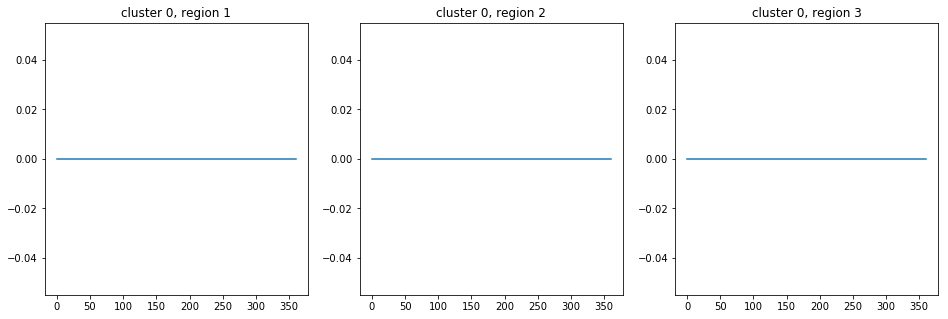

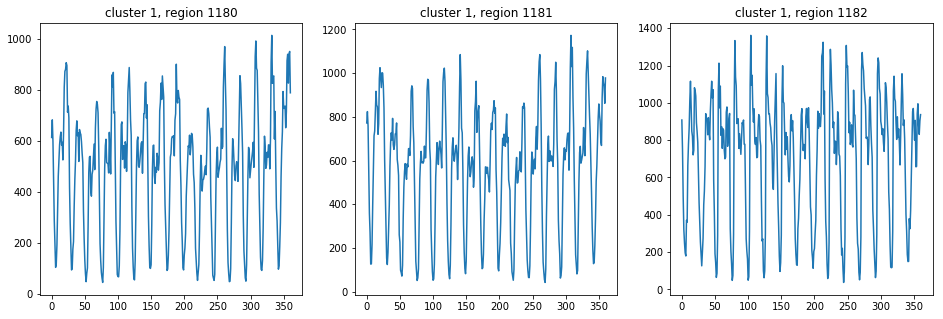

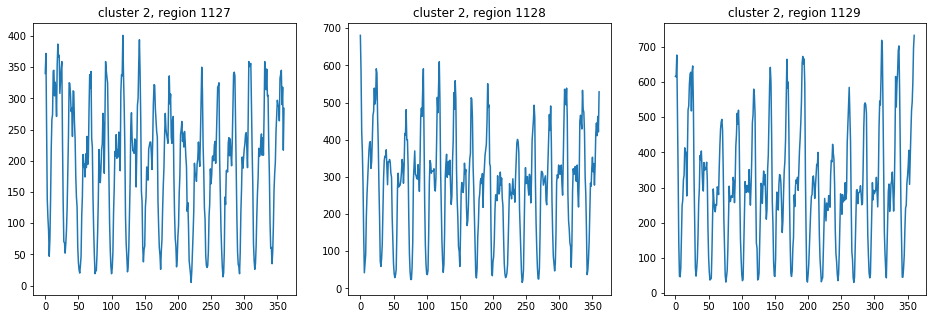

In [25]:
# отриуем 
n_clusters = 3
for i in range(n_clusters):
    plt.figure(figsize = (16,5))
    for j in range(n_clusters):
        region = clusters[clusters['cluster'] == i].index[j] #берем индекс региона
        region_data = data.loc['2016-04-15 23:00:00': '2016-04-30 23:00:00',region]
        plt.subplot(131+j)
        plt.plot(region_data.values)
        plt.title('cluster {}, region {}'.format(i,region))
    plt.show()

__4. В каждом кластере выберите наиболее типичный ряд (например, это может быть ряд, соответствующий центру кластера).__


In [26]:
for i in range(len(centers)):
    distance = []
    for j in range(1,data_norm.shape[1]+1):
        dist = cdist(centers[i].reshape(1, 20423), data_norm[j].reshape(1, 20423))
        #print i,j,dist
        distance.append(dist)
    min_dist_region = np.argmin(distance)+1
    print 'Cluster {}: {} region'.format(i, min_dist_region)

C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


Cluster 0: 1 region
Cluster 1: 1282 region
Cluster 2: 1128 region


__5. Для выбранных географических зон подберите на исходных рядах оптимальную структуру моделей — набор регрессионных признаков и значения гиперпараметров p,d,q,P,D,Q — так, как это делалось на прошлой неделе. Не используйте данные за последний имеющийся месяц — май и июнь 2016!__

### Рассмотрим Кластер 2

In [27]:
data_1128 = pd.DataFrame(data[1128])
data_1128.columns = ['n_trips']
data_1128['datetime'] = data_1128.index
data_1128.set_index(np.arange(0, data_1128.shape[0]), inplace=True)

In [28]:
data_1128.head()

,n_trips,datetime
0,645.0,2014-01-01 00:00:00
1,604.0,2014-01-01 01:00:00
2,571.0,2014-01-01 02:00:00
3,533.0,2014-01-01 03:00:00
4,383.0,2014-01-01 04:00:00


In [29]:
K=7
trend = np.arange(1, len(data_1128)+1)

for i in np.arange(1, K+1):
    data_1128['week_sin'+str(i)] = np.sin( trend*(2*np.pi*i/168.))
    data_1128['week_cos'+str(i)] = np.cos( trend*(2*np.pi*i/168.))
    
for i in range(1, 4):
    data_1128['year_sin'+str(i)] = np.sin( trend*(2*np.pi*i/8766.))
    data_1128['year_cos'+str(i)] = np.cos( trend*(2*np.pi*i/8766.))

In [30]:
data_1128.n_trips = data_1128.n_trips.astype(float64)

In [31]:
data_1128['hour'] = data_1128.datetime.apply(lambda x: x.hour)
data_1128['morning'] = data_1128.hour.apply(lambda x: 1 if x in [6,7,8] else 0)
data_1128['everning'] = data_1128.hour.apply(lambda x: 1 if x in [17,18,19] else 0)

In [32]:
data_1128.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
n_trips,645,604,571,533,383,172,97,69,76,99,145,269,306,342,371,308,270,310,337,325
datetime,2014-01-01 00:00:00,2014-01-01 01:00:00,2014-01-01 02:00:00,2014-01-01 03:00:00,2014-01-01 04:00:00,2014-01-01 05:00:00,2014-01-01 06:00:00,2014-01-01 07:00:00,2014-01-01 08:00:00,2014-01-01 09:00:00,2014-01-01 10:00:00,2014-01-01 11:00:00,2014-01-01 12:00:00,2014-01-01 13:00:00,2014-01-01 14:00:00,2014-01-01 15:00:00,2014-01-01 16:00:00,2014-01-01 17:00:00,2014-01-01 18:00:00,2014-01-01 19:00:00
week_sin1,0.0373912,0.0747301,0.111964,0.149042,0.185912,0.222521,0.258819,0.294755,0.330279,0.365341,0.399892,0.433884,0.467269,0.5,0.532032,0.56332,0.59382,0.62349,0.652287,0.680173
week_cos1,0.999301,0.997204,0.993712,0.988831,0.982566,0.974928,0.965926,0.955573,0.943883,0.930874,0.916562,0.900969,0.884115,0.866025,0.846724,0.826239,0.804598,0.781831,0.757972,0.733052
week_sin2,0.0747301,0.149042,0.222521,0.294755,0.365341,0.433884,0.5,0.56332,0.62349,0.680173,0.733052,0.781831,0.826239,0.866025,0.900969,0.930874,0.955573,0.974928,0.988831,0.997204
week_cos2,0.997204,0.988831,0.974928,0.955573,0.930874,0.900969,0.866025,0.826239,0.781831,0.733052,0.680173,0.62349,0.56332,0.5,0.433884,0.365341,0.294755,0.222521,0.149042,0.0747301
week_sin3,0.111964,0.222521,0.330279,0.433884,0.532032,0.62349,0.707107,0.781831,0.846724,0.900969,0.943883,0.974928,0.993712,1,0.993712,0.974928,0.943883,0.900969,0.846724,0.781831
week_cos3,0.993712,0.974928,0.943883,0.900969,0.846724,0.781831,0.707107,0.62349,0.532032,0.433884,0.330279,0.222521,0.111964,6.12323e-17,-0.111964,-0.222521,-0.330279,-0.433884,-0.532032,-0.62349
week_sin4,0.149042,0.294755,0.433884,0.56332,0.680173,0.781831,0.866025,0.930874,0.974928,0.997204,0.997204,0.974928,0.930874,0.866025,0.781831,0.680173,0.56332,0.433884,0.294755,0.149042
week_cos4,0.988831,0.955573,0.900969,0.826239,0.733052,0.62349,0.5,0.365341,0.222521,0.0747301,-0.0747301,-0.222521,-0.365341,-0.5,-0.62349,-0.733052,-0.826239,-0.900969,-0.955573,-0.988831


In [33]:
m2 = smf.ols('n_trips ~ week_sin1 + week_cos1 + week_sin2 + week_cos2 + week_sin3 + week_cos3 + week_sin4 +'
             'week_cos4 + week_sin5 + week_cos5 + week_sin6 + week_cos6 + week_sin7 +'
             'year_sin1 + year_sin2 + year_cos2 + year_sin3 + year_cos3 + morning + everning', data = data_1128)
             #убрала year_cos1 b week_cos7
fitted2 = m2.fit()
print fitted2.summary()

                            OLS Regression Results                            
Dep. Variable:                n_trips   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     791.3
Date:                Thu, 12 Oct 2017   Prob (F-statistic):               0.00
Time:                        11:53:46   Log-Likelihood:            -1.2683e+05
No. Observations:               20423   AIC:                         2.537e+05
Df Residuals:                   20402   BIC:                         2.539e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    299.6968      0.983    304.861      0.0

In [34]:
data_1128['reg_prediction2'] = fitted2.fittedvalues

In [35]:
resid_1128 = pd.DataFrame(fitted2.resid)
resid_1128.columns = ['resid']
resid_1128['datetime'] = data_1128.datetime
resid_1128.set_index(resid_1128.datetime, inplace = True)

In [36]:
resid_1128.head()

,resid,datetime
datetime,,
2014-01-01 00:00:00,428.977010,2014-01-01 00:00:00
2014-01-01 01:00:00,426.853206,2014-01-01 01:00:00
2014-01-01 02:00:00,425.964625,2014-01-01 02:00:00
2014-01-01 03:00:00,411.094947,2014-01-01 03:00:00
2014-01-01 04:00:00,273.620289,2014-01-01 04:00:00


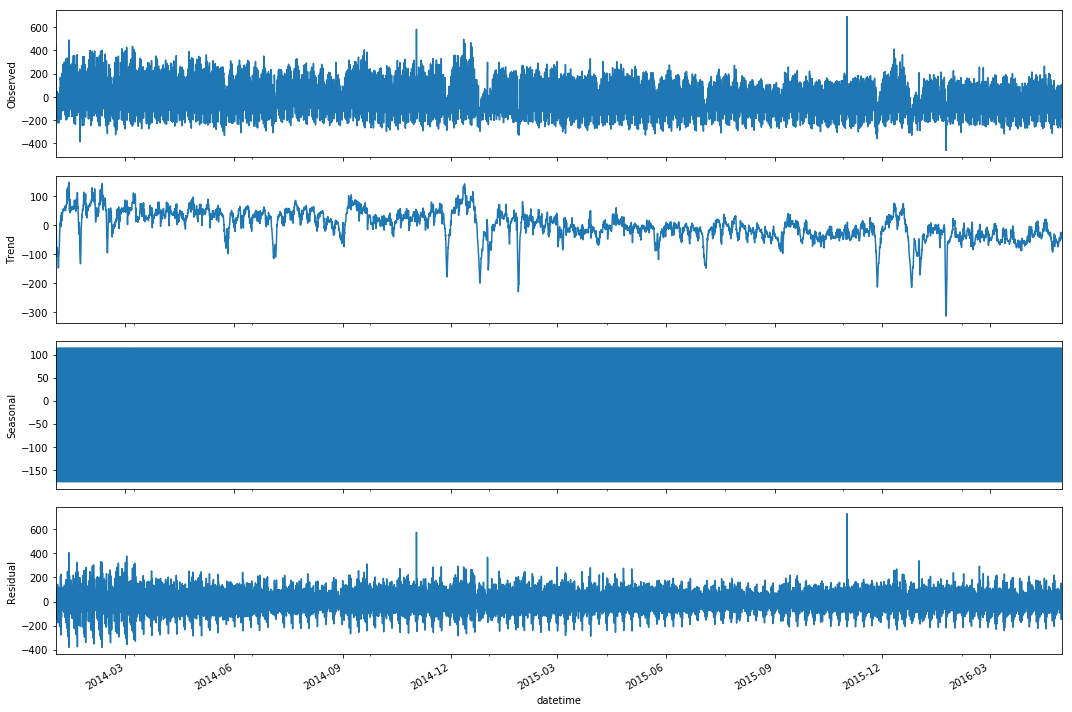

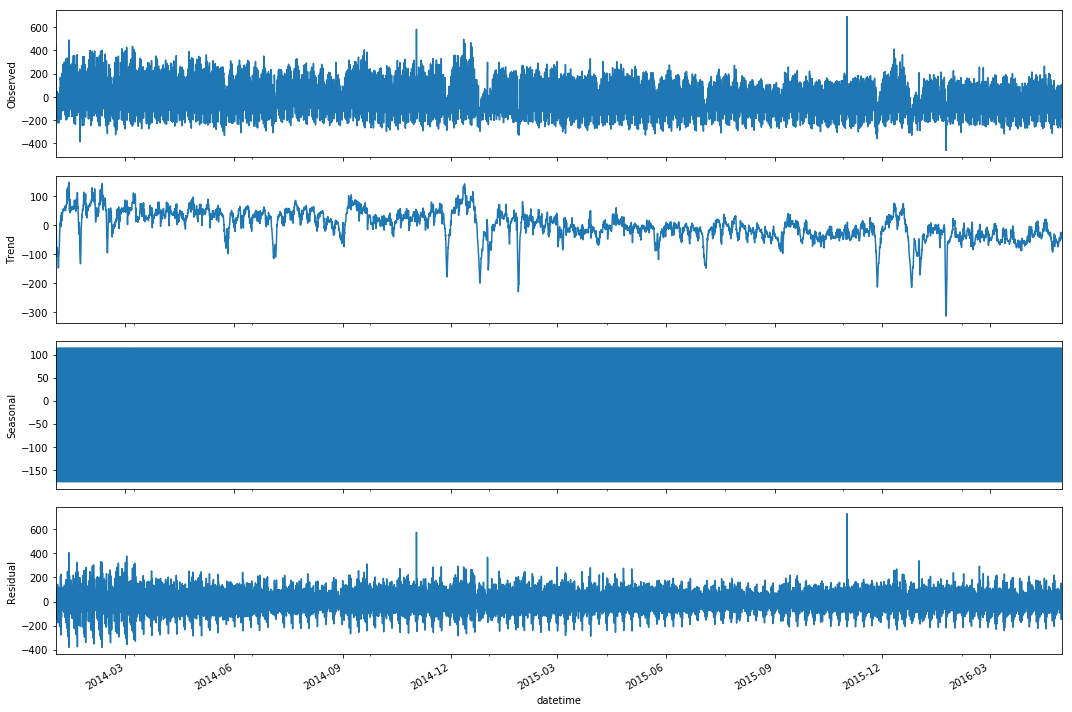

In [37]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(resid_1128.resid, freq = 24).plot()

In [27]:
print 'Критерий Дики-Фулера p-value=', sm.tsa.stattools.adfuller(resid_1128.resid)[1]

Критерий Дики-Фулера p-value= 2.10939861773e-15


Критерий Дики-Фулера отвергает гипотезу о нестационарности ряда остатков. 

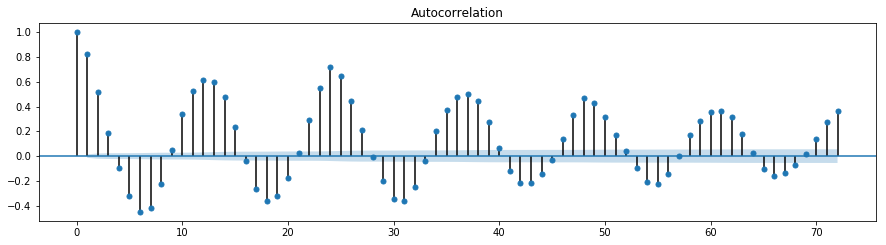

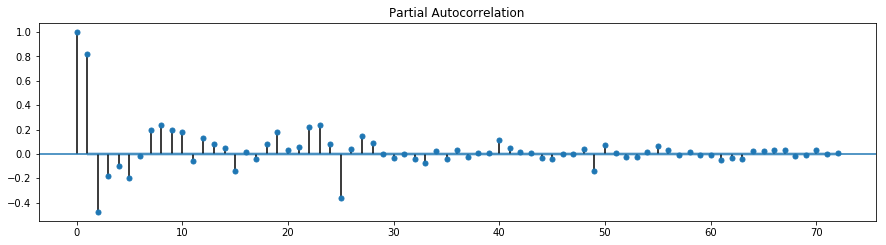

In [28]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(resid_1128.resid.squeeze(), lags = 72, ax = ax) #24часа*3дня в неделю
plt.figure(figsize(15,8))
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(resid_1128.resid.squeeze(), lags = 72, ax = ax)
pylab.show()

In [28]:
# значимых признаков много, поэтому будем выбирать оптимальные из максимально значимых
Q = 1 #24/24 S=24
q = 2
P = 1 #24/24 S=24
p = 2

In [29]:
ps = range(0, 3)
d = 0
qs = range(0, 3)
D = 0
Qs = range(0, 2)
Ps = range(0, 2)

In [30]:
from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [46]:
exog_col = ['week_sin1', 'week_cos1', 'week_sin2', 'week_cos2', 'week_sin3', 'week_cos3', 'week_sin4',\
                             'week_cos4', 'week_sin5', 'week_cos5', 'week_sin6', 'week_cos6', 'week_sin7', \
                          'year_sin1', 'year_sin2', 'year_cos2', 'year_sin3', 'year_cos3', 'morning', 'everning']
exog = data_1128[exog_col]

In [32]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(resid_1128.resid, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24), exogs = exog).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (0, 1, 0, 0))
('wrong parameters:', (0, 1, 0, 1))
('wrong parameters:', (0, 1, 1, 0))
('wrong parameters:', (0, 1, 1, 1))
('wrong parameters:', (0, 2, 1, 0))
('wrong parameters:', (0, 2, 1, 1))
Wall time: 14min 42s


In [33]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print (result_table.sort_values(by = 'aic', ascending = True)).head(10)

      parameters            aic
28  (2, 2, 1, 1)  211734.539453
24  (2, 1, 1, 1)  211932.611178
20  (2, 0, 1, 1)  213216.149008
16  (1, 2, 1, 1)  213237.824938
12  (1, 1, 1, 1)  214341.572899
27  (2, 2, 1, 0)  214907.855206
23  (2, 1, 1, 0)  215214.438143
15  (1, 2, 1, 0)  216572.980316
19  (2, 0, 1, 0)  216835.892475
11  (1, 1, 1, 0)  217506.697965


In [44]:
best_model_params = [2,2,1,1]

In [47]:
%%time
model=sm.tsa.statespace.SARIMAX(resid_1128.resid, order=(2, 0, 2), 
                                        seasonal_order=(1, 0, 1, 24), exogs = exog).fit(disp=-1)
aic = model.aic
best_model2 = model

C:\Program Files\Anaconda2\lib\site-packages\statsmodels\base\model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Wall time: 2min 41s


In [31]:
print best_model2.summary()

                                 Statespace Model Results                                 
Dep. Variable:                              resid   No. Observations:                20423
Model:             SARIMAX(2, 0, 2)x(1, 0, 1, 24)   Log Likelihood             -105860.270
Date:                            Tue, 19 Sep 2017   AIC                         211734.539
Time:                                    14:48:23   BIC                         211790.010
Sample:                                01-01-2014   HQIC                        211752.669
                                     - 04-30-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5386      0.010    157.099      0.000       1.519       1.558
ar.L2         -0.7245      0.008   

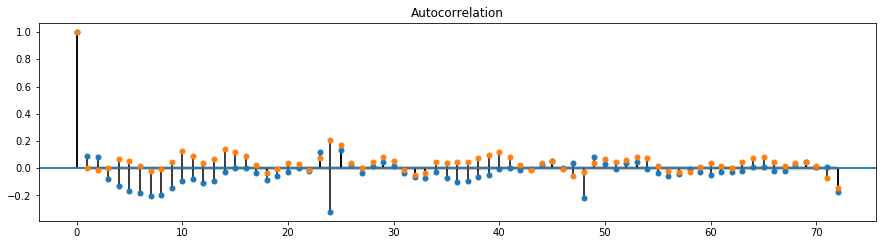

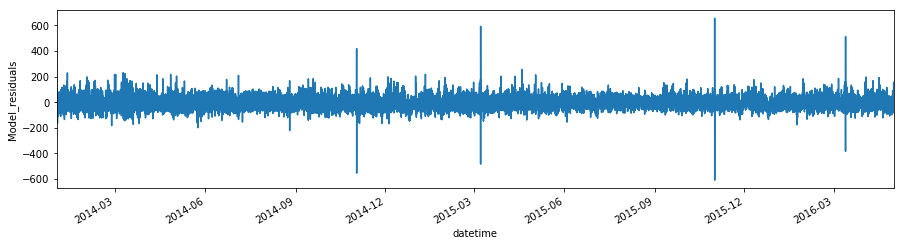

In [48]:
plt.figure(figsize(15,8))
plt.subplot(211)

best_model2.resid.plot()
plt.ylabel('Model_residuals')
sm.graphics.tsa.plot_acf(best_model2.resid.values.squeeze(), lags = 72, ax = ax)

In [49]:
print 'Критерий Стьюдента для остатков: p=%f' % stats.ttest_1samp(best_model2.resid, 0)[1]
print 'Критерий Дики-Фуллера для остатков p=%f' %sm.tsa.stattools.adfuller(best_model2.resid)[1]

Критерий Стьюдента для остатков: p=0.480530
Критерий Дики-Фуллера для остатков p=0.000000


In [50]:
data_1128['model2'] = best_model2.fittedvalues.values

In [51]:
print best_model2.fittedvalues.values

[   0.          356.99218637  328.297856   ...,  -66.98285407   52.16536582
  -48.05773135]


In [52]:
data_1128.head().T

,0,1,2,3,4
n_trips,645,604,571,533,383
datetime,2014-01-01 00:00:00,2014-01-01 01:00:00,2014-01-01 02:00:00,2014-01-01 03:00:00,2014-01-01 04:00:00
week_sin1,0.0373912,0.0747301,0.111964,0.149042,0.185912
week_cos1,0.999301,0.997204,0.993712,0.988831,0.982566
week_sin2,0.0747301,0.149042,0.222521,0.294755,0.365341
week_cos2,0.997204,0.988831,0.974928,0.955573,0.930874
week_sin3,0.111964,0.222521,0.330279,0.433884,0.532032
week_cos3,0.993712,0.974928,0.943883,0.900969,0.846724
week_sin4,0.149042,0.294755,0.433884,0.56332,0.680173
week_cos4,0.988831,0.955573,0.900969,0.826239,0.733052


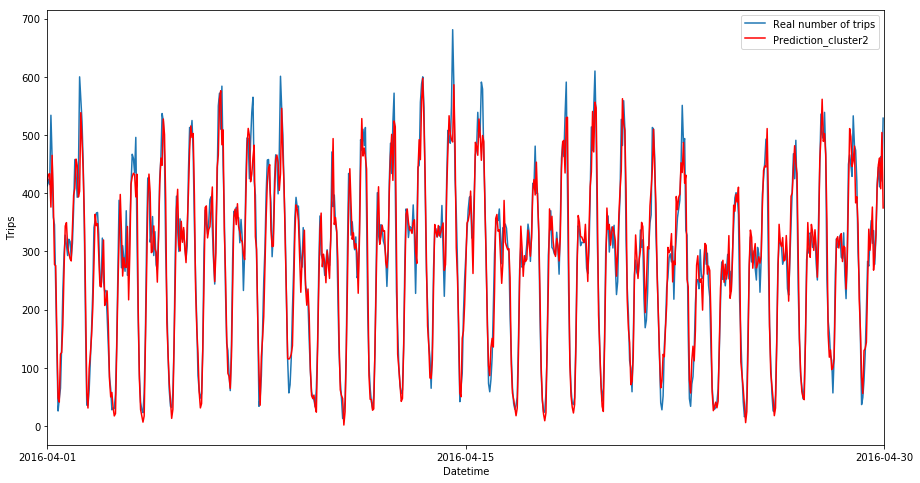

In [53]:
#соединим прогнозы моделей и посмотрим что получилось
data_1128['prediction2'] = data_1128.reg_prediction2 + data_1128.model2
plt.figure(figsize(15,8))
data_1128.n_trips[-700:].plot(label = 'Real number of trips')
data_1128.prediction2[-700:].plot(color='r', label = 'Prediction_cluster2')
plt.legend()
plt.xticks((19723, 20073, 20423), ('2016-04-01','2016-04-15',  '2016-04-30'), color='k', size=10)
plt.xlabel('Datetime')
plt.ylabel('Trips')
pylab.show()

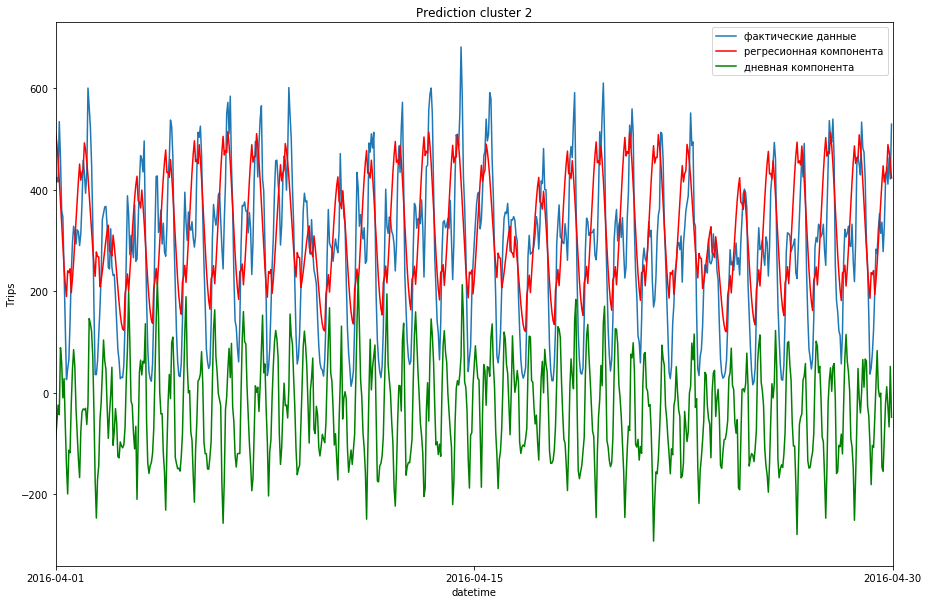

In [54]:
plt.figure(figsize(15,10))

#регресионная компонента
data_1128.n_trips[-700:].plot(label = 'фактические данные')
data_1128.reg_prediction2[-700:].plot(color='r', label = 'регресионная компонента')
data_1128.model2[-700:].plot(color='g', label = 'дневная компонента')
plt.xticks((19723, 20073, 20423), ('2016-04-01','2016-04-15',  '2016-04-30'), color='k', size=10)
plt.legend()
plt.ylabel('Trips')
plt.xlabel('datetime')
plt.title('Prediction cluster 2')
pylab.show()

In [55]:
from sklearn import metrics
print 'MSE prediction cluster 2 1128 region =%f' % metrics.mean_squared_error(data_1128.n_trips, data_1128.prediction2)

MSE prediction cluster 2 1128 region =1871.232184


In [57]:
cluster_model = dict()
cluster_model[2] = {'params': best_model_params, 's':24, 'exog': exog_col}

In [58]:
cluster_model

{2: {'exog': ['week_sin1',
   'week_cos1',
   'week_sin2',
   'week_cos2',
   'week_sin3',
   'week_cos3',
   'week_sin4',
   'week_cos4',
   'week_sin5',
   'week_cos5',
   'week_sin6',
   'week_cos6',
   'week_sin7',
   'year_sin1',
   'year_sin2',
   'year_cos2',
   'year_sin3',
   'year_cos3',
   'morning',
   'everning'],
  'params': [2, 2, 1, 1],
  's': 24}}

### Рассмотрим зону 1282 - Кластер 1

In [59]:
data_1282 = pd.DataFrame(data[1282])
data_1282.columns = ['n_trips']
data_1282['datetime'] = data_1282.index
data_1282.set_index(np.arange(0, data_1282.shape[0]), inplace=True)

data_1282.head()

,n_trips,datetime
0,1141.0,2014-01-01 00:00:00
1,1284.0,2014-01-01 01:00:00
2,1243.0,2014-01-01 02:00:00
3,1071.0,2014-01-01 03:00:00
4,512.0,2014-01-01 04:00:00


In [60]:
K=7
trend = np.arange(1, len(data_1282)+1)

for i in np.arange(1, K+1):
    data_1282['week_sin'+str(i)] = np.sin( trend*(2*np.pi*i/168.))
    data_1282['week_cos'+str(i)] = np.cos( trend*(2*np.pi*i/168.))
    
for i in range(1, 4):
    data_1282['year_sin'+str(i)] = np.sin( trend*(2*np.pi*i/8766.))
    data_1282['year_cos'+str(i)] = np.cos( trend*(2*np.pi*i/8766.))

data_1282.n_trips = data_1282.n_trips.astype(float64)

data_1282['hour'] = data_1282.datetime.apply(lambda x: x.hour)
data_1282['morning'] = data_1282.hour.apply(lambda x: 1 if x in [6,7,8] else 0)
data_1282['everning'] = data_1282.hour.apply(lambda x: 1 if x in [17,18,19] else 0)

data_1282.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
n_trips,1141,1284,1243,1071,512,220,180,161,218,301,470,753,826,768,800,728,677,802,770,766
datetime,2014-01-01 00:00:00,2014-01-01 01:00:00,2014-01-01 02:00:00,2014-01-01 03:00:00,2014-01-01 04:00:00,2014-01-01 05:00:00,2014-01-01 06:00:00,2014-01-01 07:00:00,2014-01-01 08:00:00,2014-01-01 09:00:00,2014-01-01 10:00:00,2014-01-01 11:00:00,2014-01-01 12:00:00,2014-01-01 13:00:00,2014-01-01 14:00:00,2014-01-01 15:00:00,2014-01-01 16:00:00,2014-01-01 17:00:00,2014-01-01 18:00:00,2014-01-01 19:00:00
week_sin1,0.0373912,0.0747301,0.111964,0.149042,0.185912,0.222521,0.258819,0.294755,0.330279,0.365341,0.399892,0.433884,0.467269,0.5,0.532032,0.56332,0.59382,0.62349,0.652287,0.680173
week_cos1,0.999301,0.997204,0.993712,0.988831,0.982566,0.974928,0.965926,0.955573,0.943883,0.930874,0.916562,0.900969,0.884115,0.866025,0.846724,0.826239,0.804598,0.781831,0.757972,0.733052
week_sin2,0.0747301,0.149042,0.222521,0.294755,0.365341,0.433884,0.5,0.56332,0.62349,0.680173,0.733052,0.781831,0.826239,0.866025,0.900969,0.930874,0.955573,0.974928,0.988831,0.997204
week_cos2,0.997204,0.988831,0.974928,0.955573,0.930874,0.900969,0.866025,0.826239,0.781831,0.733052,0.680173,0.62349,0.56332,0.5,0.433884,0.365341,0.294755,0.222521,0.149042,0.0747301
week_sin3,0.111964,0.222521,0.330279,0.433884,0.532032,0.62349,0.707107,0.781831,0.846724,0.900969,0.943883,0.974928,0.993712,1,0.993712,0.974928,0.943883,0.900969,0.846724,0.781831
week_cos3,0.993712,0.974928,0.943883,0.900969,0.846724,0.781831,0.707107,0.62349,0.532032,0.433884,0.330279,0.222521,0.111964,6.12323e-17,-0.111964,-0.222521,-0.330279,-0.433884,-0.532032,-0.62349
week_sin4,0.149042,0.294755,0.433884,0.56332,0.680173,0.781831,0.866025,0.930874,0.974928,0.997204,0.997204,0.974928,0.930874,0.866025,0.781831,0.680173,0.56332,0.433884,0.294755,0.149042
week_cos4,0.988831,0.955573,0.900969,0.826239,0.733052,0.62349,0.5,0.365341,0.222521,0.0747301,-0.0747301,-0.222521,-0.365341,-0.5,-0.62349,-0.733052,-0.826239,-0.900969,-0.955573,-0.988831


In [61]:
m1 = smf.ols('n_trips ~ week_sin1 + week_cos1 + week_sin2 + week_cos2 + week_sin3 + week_cos3 + week_sin4 +'
             'week_cos4 + week_sin5 + week_cos5 + week_sin6 + week_cos6 + week_sin7 +week_cos7 + '
             'year_sin1 + year_cos1 + year_sin2 + year_cos2  + year_cos3 + morning + everning', data = data_1282)
             #убрала + year_sin3   
fitted1 = m1.fit()
print fitted1.summary()

                            OLS Regression Results                            
Dep. Variable:                n_trips   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     1109.
Date:                Thu, 12 Oct 2017   Prob (F-statistic):               0.00
Time:                        12:14:39   Log-Likelihood:            -1.4341e+05
No. Observations:               20423   AIC:                         2.869e+05
Df Residuals:                   20401   BIC:                         2.870e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    674.7418      2.221    303.743      0.0

In [62]:
data_1282['reg_prediction1'] = fitted1.fittedvalues

resid_1282 = pd.DataFrame(fitted1.resid)
resid_1282.columns = ['resid']
resid_1282['datetime'] = data_1282.datetime
resid_1282.set_index(resid_1282.datetime, inplace = True)

resid_1282.head()

,resid,datetime
datetime,,
2014-01-01 00:00:00,710.478313,2014-01-01 00:00:00
2014-01-01 01:00:00,941.742664,2014-01-01 01:00:00
2014-01-01 02:00:00,966.592892,2014-01-01 02:00:00
2014-01-01 03:00:00,833.541699,2014-01-01 03:00:00
2014-01-01 04:00:00,283.905359,2014-01-01 04:00:00


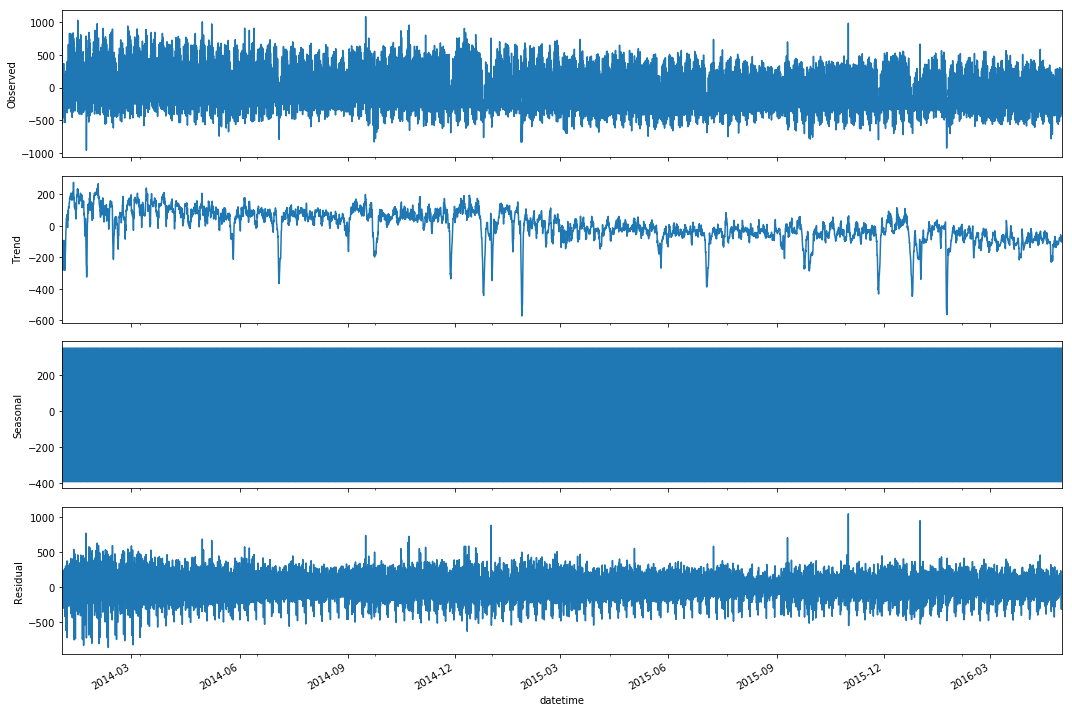

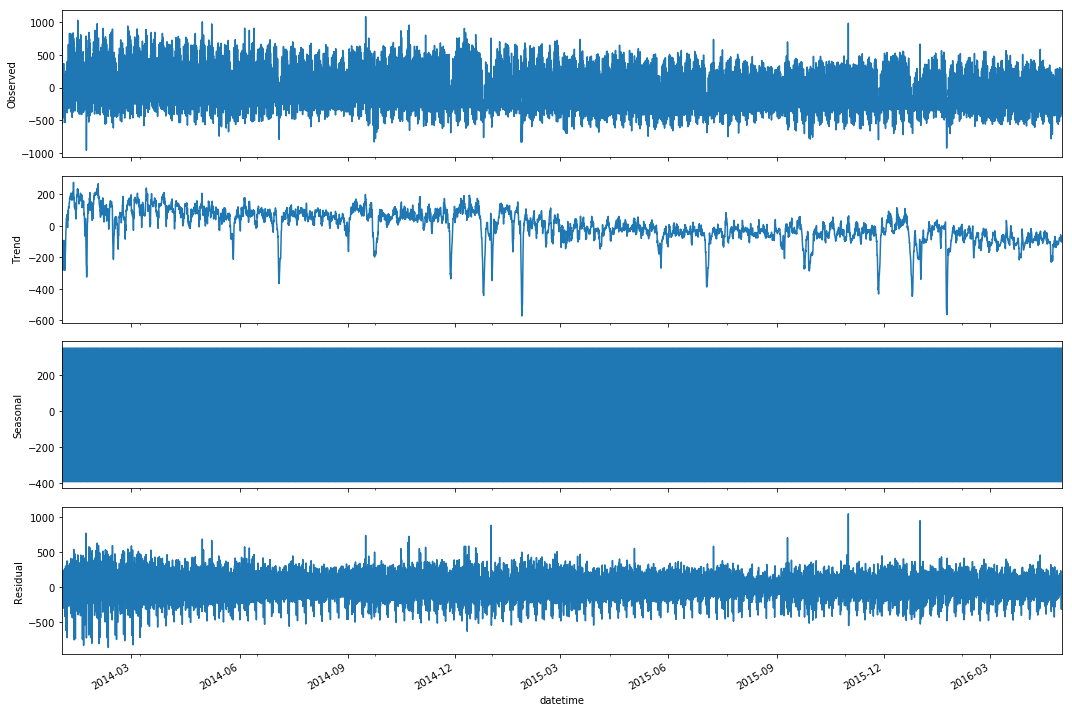

In [63]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(resid_1282.resid, freq = 24).plot()

In [64]:
print 'Критерий Дики-Фулера p-value=', sm.tsa.stattools.adfuller(resid_1282.resid)[1]

Критерий Дики-Фулера p-value= 1.52086725332e-18


Критерий Дики-Фулера отвергает гипотезу о нестационарности ряда остатков.

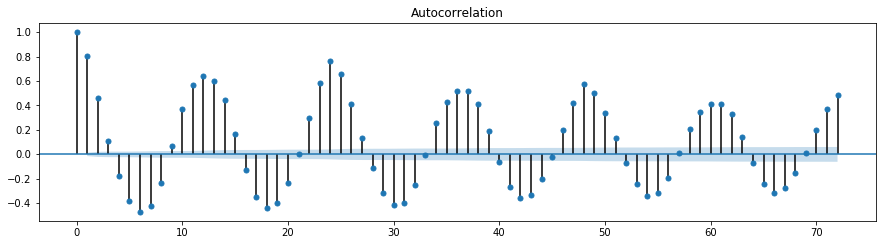

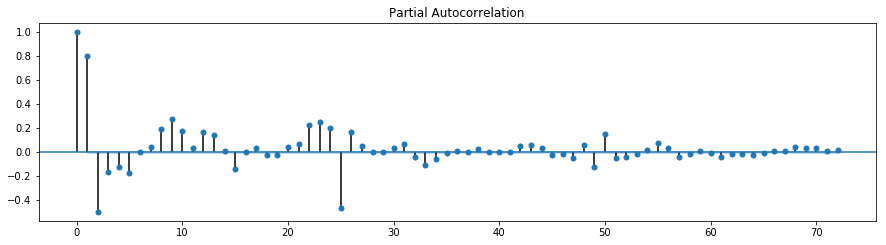

In [65]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(resid_1282.resid.squeeze(), lags = 72, ax = ax) #24часа*3дня в неделю
plt.figure(figsize(15,8))
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(resid_1282.resid.squeeze(), lags = 72, ax = ax)
pylab.show()

In [ ]:
# значимых признаков много, поэтому будем выбирать оптимальные из максимально значимых
Q = 1 #24/24 S=24
q = 1
P = 1 #24/24 S=24
p = 2

In [65]:
ps = range(0, 3)
d = 0
qs = range(0, 2)
D = 0
Qs = range(0, 2)
Ps = range(0, 2)

In [66]:
from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

24

In [66]:
exog_col = ['week_sin1', 'week_cos1', 'week_sin2', 'week_cos2', 'week_sin3', 'week_cos3', 'week_sin4',\
                             'week_cos4', 'week_sin5', 'week_cos5', 'week_sin6', 'week_cos6', 'week_sin7', \
                          'week_cos7', 'year_sin1', 'year_cos1', 'year_sin2', 'year_cos2', 'year_cos3', 'morning', 'everning']
exog = data_1282[exog_col]


In [69]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(resid_1282.resid, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24), exogs = exog).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (0, 1, 0, 0))
('wrong parameters:', (0, 1, 0, 1))
('wrong parameters:', (0, 1, 1, 0))
('wrong parameters:', (0, 1, 1, 1))
Wall time: 7min 46s


In [70]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print (result_table.sort_values(by = 'aic', ascending = True)).head(10)

      parameters            aic
18  (2, 1, 1, 1)  244908.743651
14  (2, 0, 1, 1)  244969.113910
10  (1, 1, 1, 1)  245816.736327
17  (2, 1, 1, 0)  246491.407887
13  (2, 0, 1, 0)  246895.433367
9   (1, 1, 1, 0)  247737.041377
6   (1, 0, 1, 1)  249689.847987
5   (1, 0, 1, 0)  249720.505535
16  (2, 1, 0, 1)  251235.610698
12  (2, 0, 0, 1)  252112.839800


In [67]:
best_model_params = [2,1,1,1]

In [68]:
%%time
model=sm.tsa.statespace.SARIMAX(resid_1282.resid, order=(2, 0, 1), 
                                        seasonal_order=(1, 0, 1, 24), exogs = exog).fit(disp=-1)
aic = model.aic
best_model1 = model

Wall time: 5min 29s


In [69]:
print best_model1.summary()

                                 Statespace Model Results                                 
Dep. Variable:                              resid   No. Observations:                20423
Model:             SARIMAX(2, 0, 1)x(1, 0, 1, 24)   Log Likelihood             -122448.372
Date:                            Thu, 12 Oct 2017   AIC                         244908.744
Time:                                    12:21:55   BIC                         244956.290
Sample:                                01-01-2014   HQIC                        244924.284
                                     - 04-30-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2625      0.013     94.702      0.000       1.236       1.289
ar.L2         -0.5254      0.011   

Критерий Стьюдента для остатков: p=0.743467
Критерий Дики-Фуллера для остатков p=0.000000


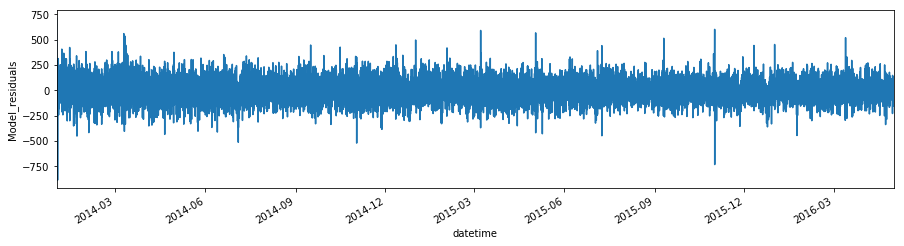

In [70]:
plt.figure(figsize(15,8))
plt.subplot(211)

best_model1.resid.plot()
plt.ylabel('Model_residuals')
sm.graphics.tsa.plot_acf(best_model1.resid.values.squeeze(), lags = 72, ax = ax)

print 'Критерий Стьюдента для остатков: p=%f' % stats.ttest_1samp(best_model1.resid, 0)[1]
print 'Критерий Дики-Фуллера для остатков p=%f' %sm.tsa.stattools.adfuller(best_model1.resid)[1]

In [71]:
data_1282['model1'] = best_model1.fittedvalues.values

print best_model1.fittedvalues.values

data_1282.head().T

[   0.          566.45886341  767.98749876 ...,    5.07263689   -9.66094151
  -22.14571318]


,0,1,2,3,4
n_trips,1141,1284,1243,1071,512
datetime,2014-01-01 00:00:00,2014-01-01 01:00:00,2014-01-01 02:00:00,2014-01-01 03:00:00,2014-01-01 04:00:00
week_sin1,0.0373912,0.0747301,0.111964,0.149042,0.185912
week_cos1,0.999301,0.997204,0.993712,0.988831,0.982566
week_sin2,0.0747301,0.149042,0.222521,0.294755,0.365341
week_cos2,0.997204,0.988831,0.974928,0.955573,0.930874
week_sin3,0.111964,0.222521,0.330279,0.433884,0.532032
week_cos3,0.993712,0.974928,0.943883,0.900969,0.846724
week_sin4,0.149042,0.294755,0.433884,0.56332,0.680173
week_cos4,0.988831,0.955573,0.900969,0.826239,0.733052


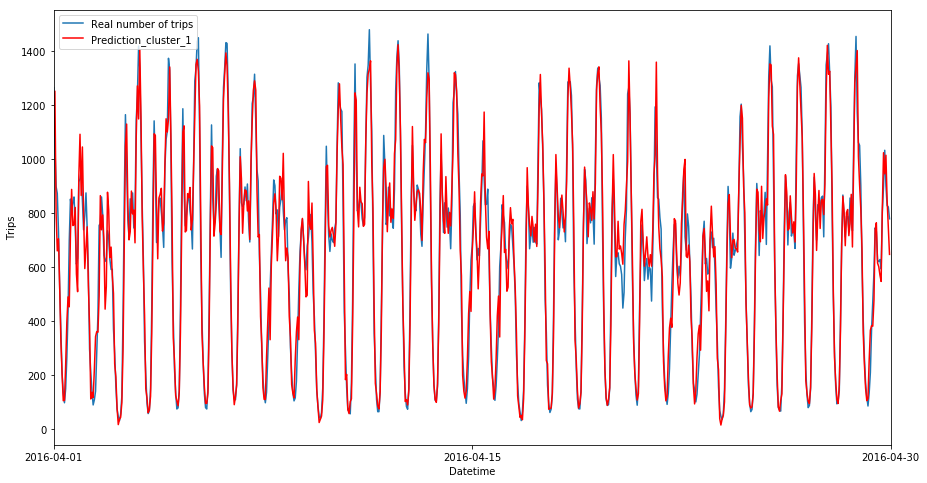

In [72]:
#соединим прогнозы моделей и посмотрим что получилось
data_1282['prediction1'] = data_1282.reg_prediction1 + data_1282.model1
plt.figure(figsize(15,8))
data_1282.n_trips[-700:].plot(label = 'Real number of trips')
data_1282.prediction1[-700:].plot(color='r', label = 'Prediction_cluster_1')
plt.legend()
plt.xticks((19723, 20073, 20423), ('2016-04-01','2016-04-15',  '2016-04-30'), color='k', size=10)
plt.xlabel('Datetime')
plt.ylabel('Trips')
pylab.show()

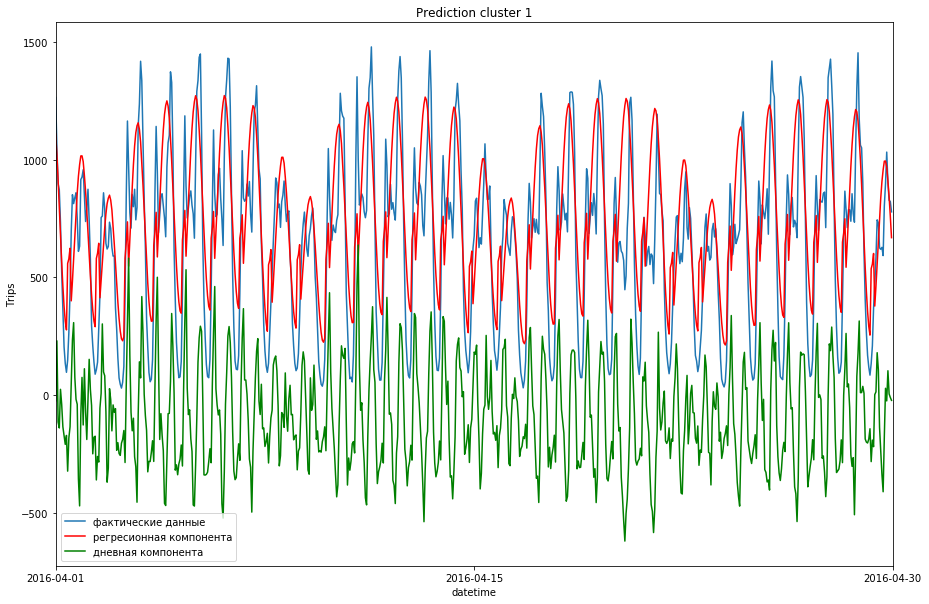

MSE prediction1 1282 region =9507.014037


In [73]:
plt.figure(figsize(15,10))

#регресионная компонента
data_1282.n_trips[-700:].plot(label = 'фактические данные')
data_1282.reg_prediction1[-700:].plot(color='r', label = 'регресионная компонента')
data_1282.model1[-700:].plot(color='g', label = 'дневная компонента')
plt.xticks((19723, 20073, 20423), ('2016-04-01','2016-04-15',  '2016-04-30'), color='k', size=10)
plt.legend()
plt.ylabel('Trips')
plt.xlabel('datetime')
plt.title('Prediction cluster 1')
pylab.show()

from sklearn import metrics
print 'MSE prediction1 1282 region =%f' % metrics.mean_squared_error(data_1282.n_trips, data_1282.prediction1)

In [74]:
cluster_model[1] = {'params': best_model_params, 's':24, 'exog': exog_col}

### Рассмотрим зону 1. Кластер 0

In [76]:
data_1 = pd.DataFrame(data[1])
data_1.columns = ['n_trips']
data_1['datetime'] = data_1.index
data_1.set_index(np.arange(0, data_1.shape[0]), inplace=True)

data_1.head()

,n_trips,datetime
0,0.0,2014-01-01 00:00:00
1,0.0,2014-01-01 01:00:00
2,0.0,2014-01-01 02:00:00
3,0.0,2014-01-01 03:00:00
4,0.0,2014-01-01 04:00:00


In [77]:
data_1.sum()

n_trips    0.0
dtype: float64

Так как данные нулевые, то можно прогноз поставить разным 0

In [54]:
data_1['prediction0']=0.

In [78]:
data_1.head()

,n_trips,datetime
0,0.0,2014-01-01 00:00:00
1,0.0,2014-01-01 01:00:00
2,0.0,2014-01-01 02:00:00
3,0.0,2014-01-01 03:00:00
4,0.0,2014-01-01 04:00:00


In [12]:
cluster_model = dict()
cluster_model[1] = {'s': 24, 'params': [2, 1, 1, 1], \
                    'exog': ['week_sin1', 'week_cos1', 'week_sin2', 'week_cos2', 'week_sin3', 'week_cos3', 'week_sin4',\
                             'week_cos4', 'week_sin5', 'week_cos5', 'week_sin6', 'week_cos6', 'week_sin7', 'week_cos7', \
                             'year_sin1', 'year_cos1', 'year_sin2', 'year_cos2', 'year_cos3', 'morning', 'everning']
                   }
cluster_model[2] = {'s': 24, 'params': [2, 2, 1, 1], \
                    'exog': ['week_sin1', 'week_cos1', 'week_sin2', 'week_cos2', 'week_sin3', 'week_cos3', 'week_sin4',\
                             'week_cos4', 'week_sin5', 'week_cos5', 'week_sin6', 'week_cos6', 'week_sin7', 'year_sin1',\
                             'year_sin2', 'year_cos2', 'year_sin3', 'year_cos3', 'morning', 'everning']
                   }

__6. Для каждой из R географических зон настройте на данных до апреля 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 постройте прогноз на 6 часов вперёд и посчитайте в ноутбуке ошибку прогноза по следующему функционалу:
Qmay=1R∗739∗6∑r=1R∑T=2016.04.3023:002016.05.3117:00∑i=16∣∣y^rT|T+i−yrT+i∣∣.__

In [13]:
print cluster_model

{1: {'s': 24, 'params': [2, 1, 1, 1], 'exog': ['week_sin1', 'week_cos1', 'week_sin2', 'week_cos2', 'week_sin3', 'week_cos3', 'week_sin4', 'week_cos4', 'week_sin5', 'week_cos5', 'week_sin6', 'week_cos6', 'week_sin7', 'week_cos7', 'year_sin1', 'year_cos1', 'year_sin2', 'year_cos2', 'year_cos3', 'morning', 'everning']}, 2: {'s': 24, 'params': [2, 2, 1, 1], 'exog': ['week_sin1', 'week_cos1', 'week_sin2', 'week_cos2', 'week_sin3', 'week_cos3', 'week_sin4', 'week_cos4', 'week_sin5', 'week_cos5', 'week_sin6', 'week_cos6', 'week_sin7', 'year_sin1', 'year_sin2', 'year_cos2', 'year_sin3', 'year_cos3', 'morning', 'everning']}}


In [20]:
regions  = clusters[(clusters['cluster'] == 1) | (clusters['cluster'] == 2)].index
regions

Index([1127, 1128, 1129, 1130, 1131, 1178, 1179, 1180, 1181, 1182, 1183, 1228,
       1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1281, 1282, 1283, 1284,
       1286, 1287, 1333, 1334, 1335, 1384, 1385, 1386, 1735, 1784],
      dtype='object')

In [166]:
data.columns.isin(regions.values)

array([False, False, False, ..., False, False, False], dtype=bool)

In [21]:
anouther_regions = data.columns[~data.columns.isin(regions.values)]
print len(anouther_regions), len(clusters.index), len(regions)

2466 2500 34


In [22]:
raw_data = raw_data.T
raw_data['datetime'] = raw_data.index
raw_data['datetime']  = raw_data['datetime'].apply(pd.to_datetime, format  = '%Y%m%d%H')
raw_data.set_index(raw_data.datetime, inplace=True)
raw_data.drop('datetime', axis=1, inplace=True)

In [23]:
raw_data.tail()

,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
datetime,,,,,,,,,,,,,,,,,,,,,
2016-06-30 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-30 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-30 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-30 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-30 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
#raw_data.drop(['datetime'], inplace=True)

In [24]:
print cluster_model[1]

{'s': 24, 'params': [2, 1, 1, 1], 'exog': ['week_sin1', 'week_cos1', 'week_sin2', 'week_cos2', 'week_sin3', 'week_cos3', 'week_sin4', 'week_cos4', 'week_sin5', 'week_cos5', 'week_sin6', 'week_cos6', 'week_sin7', 'week_cos7', 'year_sin1', 'year_cos1', 'year_sin2', 'year_cos2', 'year_cos3', 'morning', 'everning']}


In [25]:
cluster_model[1]['params']

[2, 1, 1, 1]

In [45]:
%%time
ERR = []
for region in regions:
    end_april = '2016-04-30 23:00:00'
    begin_may = '2016-05-01 00:00:00'
    end_may = '2016-05-31 23:00:00'
    cluster_id  = clusters.loc[region, 'cluster']
    model_params = cluster_model[cluster_id]
    param = model_params['params']
    exog_col = model_params['exog']
    
    full_data = pd.DataFrame(raw_data.loc[:, [region, 'datetime']])
    full_data.columns = ['n_trips', 'datetime']
    full_data.n_trips = full_data.n_trips.astype(float64)
        
    full_data['datetime'] = full_data.index
    full_data['hour'] = full_data.datetime.apply(lambda x: x.hour)
        
    full_data['morning'] = full_data.hour.apply(lambda x: 1 if x in [6,7,8] else 0)
    full_data['everning'] = full_data.hour.apply(lambda x: 1 if x in [17,18,19] else 0)
     # добавляем синусы и косинусы
    K=7
    trend = np.arange(1, len(full_data)+1)

    for i in np.arange(1, K+1):
        full_data['week_sin'+str(i)] = np.sin( trend*(2*np.pi*i/168.))
        full_data['week_cos'+str(i)] = np.cos( trend*(2*np.pi*i/168.))
    
    for i in range(1, 4):
        full_data['year_sin'+str(i)] = np.sin( trend*(2*np.pi*i/8766.))
        full_data['year_cos'+str(i)] = np.cos( trend*(2*np.pi*i/8766.))
   
    #обучение по данных по апрель
    train_data = full_data[:end_april]
    m1 = smf.ols('n_trips ~ week_sin1 + week_cos1 + week_sin2 + week_cos2 + week_sin3 + week_cos3 + week_sin4 +'
             'week_cos4 + week_sin5 + week_cos5 + week_sin6 + week_cos6 + week_sin7 +week_cos7 + '
             'year_sin1 + year_cos1 + year_sin2 + year_cos2  + + year_sin3 + year_cos3 + morning + everning', data = train_data)
    fitted1 = m1.fit()
    #предсказание всех данных 
    full_data['reg_prediction'] = fitted1.predict(full_data)

    resid_t = pd.DataFrame(data = (full_data.n_trips - full_data.reg_prediction).values,\
                           index = full_data.index, columns= ['resid'])
    resid_train = resid_t[:end_april]
    
    
    model2=sm.tsa.statespace.SARIMAX(resid_train, order=(param[0], 0, param[1]), 
                                        seasonal_order=(param[2], 0, [param[3]], 24), \
                                     exogs = train_data[exog_col]).fit(disp=-1)
    #aic = model2.aic
    #best_model2 = model2
    #full_data['model_prediction'] = best_model2.fittedvalues.values
    
    model2_2=sm.tsa.statespace.SARIMAX(resid_t, order=(param[0], 0, param[1]), 
                                        seasonal_order=(param[2], 0, [param[3]], 24),\
                                       exogs = full_data[exog_col]).filter(model2.params)
    ERR = []
    err1 = 0.0                       
    data_may = pd.date_range('2016-05-01 00:00:00', '2016-05-31 23:00:00', freq='1H')
    
    for d in range(0, len(data_may)-6):
                              
        start_day = 20423+d 
        end_day = 20423+6+d
        start_day_2 = data_may[d]
        end_day_2 = data_may[d+6]
            
        sarimax_pred = model2_2.predict(start = start_day, end = end_day, dynamic=True)
        lr_pred = full_data.loc[start_day_2:end_day_2, 'reg_prediction']
        hours_prediction = lr_pred + sarimax_pred 
        y = full_data.loc[start_day_2:end_day_2,'n_trips']
        err1 +=np.abs(y-hours_prediction).sum()
    ERR.append(err1)
    print 'region ', region, 'error = ', err1
    

print 'ERR total = ', np.sum(ERR)
     

C:\Program Files\Anaconda2\lib\site-packages\statsmodels\base\model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region  1127 error =  158691.144345


C:\Program Files\Anaconda2\lib\site-packages\statsmodels\base\model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region  1128 error =  257280.589007
region  1129 error =  287388.93632
region  1130 error =  362434.119386
region  1131 error =  439843.422008
region  1178 error =  412502.081045
region  1179 error =  424199.110958
region  1180 error =  359164.13821
region  1181 error =  417949.960118
region  1182 error =  622969.627139
region  1183 error =  383480.34277
region  1228 error =  278555.630047
region  1229 error =  412887.385822
region  1230 error =  398091.92465
region  1231 error =  556638.405529
region  1232 error =  505000.276187
region  1233 error =  529310.598177
region  1234 error =  424578.6353


ValueError: Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.

In [ ]:
    

#считаем ощибку на всех остальных регинах из кластера 0
anouther_regions = data.columns[~data.columns.isin(regions.values)]
for region in anouther_regions:
        full_data = pd.DataFrame(raw_data[region, datetime])
        full_data.columns = ['n_trip']
        full_data.n_trips = full_data.n_trips.astype(float64)
        
        pred = 0
        dd =0
        err2 = 0.
        for d in range(0, len(data_may)+1):
                              
            start_day = data_may[dd] 
            end_day = data_may[d+6]
            y = full_data['n_trips']
            err2 +=np.abs(y[start_day:end_day] - 0.).sum()
            dd +=1                   
         
                           
#Общая ошибка                           
full_error = (err1 + err2)/(2500*739*6.)
print full_error
     

In [87]:
region = 1127
cluster_id  = clusters.loc[region, 'cluster']
print cluster_id
print cluster_model[2]

2
{'s': 24, 'params': [2, 2, 1, 1], 'exog': ['week_sin1', 'week_cos1', 'week_sin2', 'week_cos2', 'week_sin3', 'week_cos3', 'week_sin4', 'week_cos4', 'week_sin5', 'week_cos5', 'week_sin6', 'week_cos6', 'week_sin7', 'year_sin1', 'year_sin2', 'year_cos2', 'year_sin3', 'year_cos3', 'morning', 'everning']}


In [28]:
# тест на регионе 1127

region = 1127

end_april = '2016-04-30 23:00:00'
begin_may = '2016-05-01 00:00:00'
end_may = '2016-05-31 23:00:00'
cluster_id  = clusters.loc[region, 'cluster']
model_params = cluster_model[cluster_id]
param = model_params['params']
exog_col = model_params['exog']
    
full_data = pd.DataFrame(raw_data.loc[:, [region, 'datetime']])
full_data.columns = ['n_trips', 'datetime']
full_data.n_trips = full_data.n_trips.astype(float64)
        
full_data['datetime'] = full_data.index
full_data['hour'] = full_data.datetime.apply(lambda x: x.hour)
        
full_data['morning'] = full_data.hour.apply(lambda x: 1 if x in [6,7,8] else 0)
full_data['everning'] = full_data.hour.apply(lambda x: 1 if x in [17,18,19] else 0)
     # добавляем синусы и косинусы
K=7
trend = np.arange(1, len(full_data)+1)

for i in np.arange(1, K+1):
        full_data['week_sin'+str(i)] = np.sin( trend*(2*np.pi*i/168.))
        full_data['week_cos'+str(i)] = np.cos( trend*(2*np.pi*i/168.))
    
for i in range(1, 4):
        full_data['year_sin'+str(i)] = np.sin( trend*(2*np.pi*i/8766.))
        full_data['year_cos'+str(i)] = np.cos( trend*(2*np.pi*i/8766.))

In [29]:
#обучение по данных по апрель
train_data = full_data[:end_april]
m1 = smf.ols('n_trips ~ week_sin1 + week_cos1 + week_sin2 + week_cos2 + week_sin3 + week_cos3 + week_sin4 +'
             'week_cos4 + week_sin5 + week_cos5 + week_sin6 + week_cos6 + week_sin7 +week_cos7 + '
             'year_sin1 + year_cos1 + year_sin2 + year_cos2  + + year_sin3 + year_cos3 + morning + everning', data = train_data)
fitted1 = m1.fit()
#предсказание всех данных 
full_data['reg_prediction'] = fitted1.predict(full_data)

resid_t = pd.DataFrame(data = (full_data.n_trips - full_data.reg_prediction).values,\
                           index = full_data.index, columns= ['resid'])
resid_train = resid_t[:end_april]

In [30]:
resid_t.tail()

,resid
datetime,
2016-06-30 19:00:00,60.828559
2016-06-30 20:00:00,17.672160
2016-06-30 21:00:00,69.047198
2016-06-30 22:00:00,56.950487
2016-06-30 23:00:00,28.354679


In [31]:
resid_train.tail()

,resid
datetime,
2016-04-30 19:00:00,20.477633
2016-04-30 20:00:00,-18.820393
2016-04-30 21:00:00,30.851128
2016-04-30 22:00:00,-44.250830
2016-04-30 23:00:00,51.134956


In [32]:
%%time
model2=sm.tsa.statespace.SARIMAX(resid_train, order=(param[0], 0, param[1]), 
                                        seasonal_order=(param[2], 0, [param[3]], 24), \
                                     exogs = train_data[exog_col]).fit(disp=-1)
    #aic = model2.aic
    #best_model2 = model2
    #full_data['model_prediction'] = best_model2.fittedvalues.values
   


C:\Program Files\Anaconda2\lib\site-packages\statsmodels\base\model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Wall time: 2min 15s


In [33]:
%%time
model2_2=sm.tsa.statespace.SARIMAX(resid_t, order=(param[0], 0, param[1]), 
                                        seasonal_order=(param[2], 0, [param[3]], 24),\
                                       exogs = full_data[exog_col]).filter(model2.params)

Wall time: 6.36 s


In [34]:
full_data.shape

(21887, 26)

In [41]:
ERR = []
err1 = 0.0                       
data_may = pd.date_range('2016-05-01 00:00:00', '2016-05-31 23:00:00', freq='1H')
    
for d in range(0, len(data_may)-6):
                              
        start_day = 20423+d 
        end_day = 20423+6+d
        start_day_2 = data_may[d]
        end_day_2 = data_may[d+6]
            
        sarimax_pred = model2_2.predict(start = start_day, end = end_day, dynamic=True)
        lr_pred = full_data.loc[start_day_2:end_day_2, 'reg_prediction']
        hours_prediction = lr_pred + sarimax_pred 
        y = full_data.loc[start_day_2:end_day_2,'n_trips']
        err1 +=np.abs(y-hours_prediction).sum()
ERR.append(err1)
print 'region ', region, 'error = ', err1


region  1127 error = 

NameError: name 'err_1' is not defined

In [42]:
print 'region ', region, 'error = ', err1

 region  1127 error =  158691.144345


In [44]:
err1/(739*6)

35.78961306835182

In [ ]:
    
    err1 = 0.0                       
    data_may = pd.date_range('2016-05-01 00:00:00', '2016-05-31 17:00:00', freq='1H')
    
    for d in range(0, len(data_may)+1):
                              
            start_day = 20423+d 
            end_day = 20423+6+d
            start_day_2 = data_may[d]
            end_day_2 = data_may[d+6]
            
            sarimax_pred = model2_2.predict(start = start_day, end = end_day, dynamic=True)
            lr_pred = full_data.loc[start_day_2:end_day_2, 'reg_prediction']
            hours_prediction = lr_pred + sarimax_pred 
            y = full_data.loc[start_day_2:end_day_2,'n_trips']
            err1 +=np.abs(y-hours_prediction).sum()
            

In [27]:
len(data_may)

738

In [215]:
print start_day_2

 2016-05-01 00:00:00


In [222]:
lr_pred = full_data.loc[start_day_2:end_day_2, 'reg_prediction']
hours_prediction = lr_pred + sarimax_pred 
y = full_data.loc[start_day_2:end_day_2,'n_trips']
print lr_pred, sarimax_pred, hours_prediction, y

datetime
2016-05-01 00:00:00    203.877676
2016-05-01 01:00:00    176.189849
2016-05-01 02:00:00    151.584952
2016-05-01 03:00:00    131.604856
2016-05-01 04:00:00    117.443645
2016-05-01 05:00:00    109.866200
2016-05-01 06:00:00    163.958519
Name: reg_prediction, dtype: float64 datetime
2016-05-01 00:00:00    29.428701
2016-05-01 01:00:00    -0.495281
2016-05-01 02:00:00   -24.569157
2016-05-01 03:00:00   -36.453206
2016-05-01 04:00:00   -37.549177
2016-05-01 05:00:00   -37.395702
2016-05-01 06:00:00   -56.616355
dtype: float64 datetime
2016-05-01 00:00:00    233.306376
2016-05-01 01:00:00    175.694568
2016-05-01 02:00:00    127.015795
2016-05-01 03:00:00     95.151650
2016-05-01 04:00:00     79.894469
2016-05-01 05:00:00     72.470498
2016-05-01 06:00:00    107.342164
dtype: float64 datetime
2016-05-01 00:00:00    259.0
2016-05-01 01:00:00    121.0
2016-05-01 02:00:00     86.0
2016-05-01 03:00:00     59.0
2016-05-01 04:00:00     64.0
2016-05-01 05:00:00     46.0
2016-05-01 06:00

In [223]:
err = np.abs(y-hours_prediction).sum()

In [224]:
print err

239.262766762


datetime
2016-05-01 00:00:00    25.693624
2016-05-01 01:00:00    54.694568
2016-05-01 02:00:00    41.015795
2016-05-01 03:00:00    36.151650
2016-05-01 04:00:00    15.894469
2016-05-01 05:00:00    26.470498
2016-05-01 06:00:00    39.342164
dtype: float64

In [204]:
err1 = 0.0                       
data_may = pd.date_range('2016-04-30 23:00:00', '2016-05-31 17:00:00', freq='1H')
    
for d in range(0, len(data_may)+1):
                              
        start_day = 40424+1+d
        start_day_2 = data_may[d]
        end_day = 40424+1+6+d
        end_day_2 = data_may[d+6]
        sarimax_pred = model2_2.predict(start = start_day, end = end_day, dynamic=True)
        lr_pred = full_data.loc[start_day_2:end_day_2, 'reg_prediction']
        hours_prediction = lr_pred + sarimax_pred 
        y = full_data['n_trips']
        err1 +=np.abs(y[start_day_2:end_day_2] - hours_prediction).sum()

ValueError: Start must be <= len(endog)

In [139]:
dd = 0
quality_t = 0.0                       
data_may = pd.date_range('2016-04-30 23:00:00', '2016-05-31 17:00:00', freq='1H')
data_may[0]

Timestamp('2016-04-30 23:00:00', freq='H')

In [148]:
start_day = data_may[dd] 
end_day = data_may[dd+6]
print start_day, end_day

 2016-04-30 23:00:00 2016-05-01 05:00:00


In [187]:
full_data.shape[0]

21887

In [196]:
data.shape[0]

20423

In [70]:
data_full_1128 = pd.DataFrame(raw_data.loc[1128, '2014010100':'2016053117'])
data_full_1128.columns = ['n_trips']
data_full_1128['datetime'] = data_full_1128.index
data_full_1128['datetime']  = data_full_1128['datetime'].apply(pd.to_datetime, format  = '%Y%m%d%H')
data_full_1128.set_index(data_full_1128.datetime, inplace=True)

In [71]:
data_full_1128.tail()

,n_trips,datetime
datetime,,
2016-05-31 13:00:00,240.0,2016-05-31 13:00:00
2016-05-31 14:00:00,261.0,2016-05-31 14:00:00
2016-05-31 15:00:00,258.0,2016-05-31 15:00:00
2016-05-31 16:00:00,189.0,2016-05-31 16:00:00
2016-05-31 17:00:00,266.0,2016-05-31 17:00:00


In [72]:
K=7
trend = np.arange(1, len(data_full_1128)+1)

for i in np.arange(1, K+1):
    data_full_1128['week_sin'+str(i)] = np.sin( trend*(2*np.pi*i/168.))
    data_full_1128['week_cos'+str(i)] = np.cos( trend*(2*np.pi*i/168.))
    
for i in range(1, 4):
    data_full_1128['year_sin'+str(i)] = np.sin( trend*(2*np.pi*i/8766.))
    data_full_1128['year_cos'+str(i)] = np.cos( trend*(2*np.pi*i/8766.))
    
data_full_1128['hour'] = data_full_1128.datetime.apply(lambda x: x.hour)
data_full_1128['morning'] = data_full_1128.hour.apply(lambda x: 1 if x in [6,7,8] else 0)
data_full_1128['everning'] = data_full_1128.hour.apply(lambda x: 1 if x in [17,18,19] else 0)

In [89]:
data_full_1128.head().T

datetime,2014-01-01 00:00:00,2014-01-01 01:00:00,2014-01-01 02:00:00,2014-01-01 03:00:00,2014-01-01 04:00:00
n_trips,645,604,571,533,383
datetime,2014-01-01 00:00:00,2014-01-01 01:00:00,2014-01-01 02:00:00,2014-01-01 03:00:00,2014-01-01 04:00:00
week_sin1,0.0373912,0.0747301,0.111964,0.149042,0.185912
week_cos1,0.999301,0.997204,0.993712,0.988831,0.982566
week_sin2,0.0747301,0.149042,0.222521,0.294755,0.365341
week_cos2,0.997204,0.988831,0.974928,0.955573,0.930874
week_sin3,0.111964,0.222521,0.330279,0.433884,0.532032
week_cos3,0.993712,0.974928,0.943883,0.900969,0.846724
week_sin4,0.149042,0.294755,0.433884,0.56332,0.680173
week_cos4,0.988831,0.955573,0.900969,0.826239,0.733052


In [77]:
m2 = smf.ols('n_trips ~ week_sin1 + week_cos1 + week_sin2 + week_cos2 + week_sin3 + week_cos3 + week_sin4 +'
             'week_cos4 + week_sin5 + week_cos5 + week_sin6 + week_cos6 + week_sin7 +'
             'year_sin1 + year_sin2 + year_cos2 + year_sin3 + year_cos3 + morning + everning',\
             data = data_full_1128[:'2016-04-30 23:00:00'])
             #убрала year_cos1 b week_cos7
fitted2 = m2.fit()
print fitted2.summary()

                            OLS Regression Results                            
Dep. Variable:                n_trips   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     791.3
Date:                Tue, 19 Sep 2017   Prob (F-statistic):               0.00
Time:                        16:03:51   Log-Likelihood:            -1.2683e+05
No. Observations:               20423   AIC:                         2.537e+05
Df Residuals:                   20402   BIC:                         2.539e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    299.6968      0.983    304.861      0.0

In [78]:
data_full_1128['reg_prediction2'] = fitted2.fittedvalues

In [96]:
data_full_1128['resid2'] = fitted2.resid

In [84]:
data_full_1128.loc['2016-04-30 23:00:00' : '2016-05-31 17:00:00', 'reg_prediction2'] = fitted2.predict(data_full_1128['2016-04-30 23:00:00' : '2016-05-31 17:00:00'])

In [86]:
exog_col = ['week_sin1', 'week_cos1', 'week_sin2', 'week_cos2', 'week_sin3', 'week_cos3', 'week_sin4',\
                             'week_cos4', 'week_sin5', 'week_cos5', 'week_sin6', 'week_cos6', 'week_sin7', \
                          'year_sin1', 'year_sin2', 'year_cos2', 'year_sin3', 'year_cos3', 'morning', 'everning']
exog_1128 = data_full_1128[exog_col]

In [97]:
%%time
model2=sm.tsa.statespace.SARIMAX(data_full_1128.resid2[:'2016-04-30 23:00:00'], order=(2, 0, 2), 
                                        seasonal_order=(1, 0, 1, 24), exogs = exog_1128).fit(disp=-1)
aic = model2.aic
best_model2 = model2

C:\Program Files\Anaconda2\lib\site-packages\statsmodels\base\model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Wall time: 1min 37s


In [103]:
data_full_1128['model2'] = 0
data_full_1128.loc[:'2016-04-30 23:00:00','model2'] = best_model2.fittedvalues.values

In [148]:
data_full_1128.tail().T

datetime,2016-05-31 13:00:00,2016-05-31 14:00:00,2016-05-31 15:00:00,2016-05-31 16:00:00,2016-05-31 17:00:00
n_trips,240,261,258,189,266
datetime,2016-05-31 13:00:00,2016-05-31 14:00:00,2016-05-31 15:00:00,2016-05-31 16:00:00,2016-05-31 17:00:00
week_sin1,-0.399892,-0.365341,-0.330279,-0.294755,-0.258819
week_cos1,0.916562,0.930874,0.943883,0.955573,0.965926
week_sin2,-0.733052,-0.680173,-0.62349,-0.56332,-0.5
week_cos2,0.680173,0.733052,0.781831,0.826239,0.866025
week_sin3,-0.943883,-0.900969,-0.846724,-0.781831,-0.707107
week_cos3,0.330279,0.433884,0.532032,0.62349,0.707107
week_sin4,-0.997204,-0.997204,-0.974928,-0.930874,-0.866025
week_cos4,-0.0747301,0.0747301,0.222521,0.365341,0.5


In [142]:
model2_2=sm.tsa.statespace.SARIMAX(data_full_1128.resid2, order=(2, 0, 2), 
                                        seasonal_order=(1, 0, 1, 24), exogs = exog_1128).filter(model2.params)
aic = model2_2.aic
best_model2_2 = model2_2

In [260]:
time_range = data_full_1128.index[21160:]
print len(time_range)
time_range[0], time_range[-1]

1


(Timestamp('2016-05-31 17:00:00'), Timestamp('2016-05-31 17:00:00'))

In [185]:
time_range[0]+relativedelta(hour=6)

Timestamp('2016-04-30 06:00:00')

In [205]:
data_full_1128.loc['2016-05-31 17:00:00', 'n_trips']

266.0

In [254]:
data_full_1128.index[20423]

Timestamp('2016-05-01 00:00:00')

In [230]:
data_full_1128.index[20445]+relativedelta(hours=5)

Timestamp('2016-05-02 03:00:00')

In [261]:
mse=0
for time in range(20422,21160):
    predicted_data = model2_2.predict(time+1, time+6, dynamic=True).values
    time_0 = data_full_1128.index[time+1]
    mse_hour=0
    for j, pred in enumerate(predicted_data):
        times = time_0 + relativedelta(hours=j)
        mse_hour = mse_hour+ abs(pred-data_full_1128.loc[times, 'n_trips']+data_full_1128.loc[times, 'reg_prediction2'])
    time_0 = time_0 + relativedelta(hours=1)
    mse = mse+mse_hour
print mse

KeyError: 'the label [2016-05-31 18:00:00] is not in the [index]'

In [262]:
mse/(738*6)

59.924080873042854

In [144]:
start_time = data_full_1128.loc[:'2016-04-30 23:00:00', :].shape[0]
end_time = data_full_1128.loc[:'2016-05-31 17:00:00', :].shape[0]
print start_time, end_time

20423 21161


In [145]:
prediction = model2_2.predict(dynamic=True, start=start_time,\
                              end=end_time)

In [155]:
data_full_1128.loc['2016-04-30 23:00:00':,'model2'] = model2_2.predict(dynamic=True, start=start_time,\
                              end=end_time).values

In [161]:
data_full_1128.tail(20)

,n_trips,datetime,week_sin1,week_cos1,week_sin2,week_cos2,week_sin3,week_cos3,week_sin4,week_cos4,...,year_sin3,year_cos3,hour,morning,everning,reg_prediction2,resid,model2,resid2,prediction2
datetime,,,,,,,,,,,,,,,,,,,,,
2016-05-30 22:00:00,178.0,2016-05-30 22:00:00,-0.826239,0.563320,-0.930874,-3.653410e-01,-0.222521,-9.749279e-01,6.801727e-01,-0.733052,...,0.995827,0.091261,22,0,0,328.886804,NaN,36.531288,NaN,365.418093
2016-05-30 23:00:00,131.0,2016-05-30 23:00:00,-0.804598,0.593820,-0.955573,-2.947552e-01,-0.330279,-9.438833e-01,5.633201e-01,-0.826239,...,0.996021,0.089119,23,0,0,290.415933,NaN,-18.899147,NaN,271.516785
2016-05-31 00:00:00,87.0,2016-05-31 00:00:00,-0.781831,0.623490,-0.974928,-2.225209e-01,-0.433884,-9.009689e-01,4.338837e-01,-0.900969,...,0.996210,0.086977,0,0,0,251.119330,NaN,-50.924322,NaN,200.195008
2016-05-31 01:00:00,47.0,2016-05-31 01:00:00,-0.757972,0.652287,-0.988831,-1.490423e-01,-0.532032,-8.467242e-01,2.947552e-01,-0.955573,...,0.996395,0.084835,1,0,0,213.730069,NaN,-71.081013,NaN,142.649056
2016-05-31 02:00:00,32.0,2016-05-31 02:00:00,-0.733052,0.680173,-0.997204,-7.473009e-02,-0.623490,-7.818315e-01,1.490423e-01,-0.988831,...,0.996575,0.082692,2,0,0,180.882417,NaN,-77.306699,NaN,103.575718
2016-05-31 03:00:00,21.0,2016-05-31 03:00:00,-0.707107,0.707107,-1.000000,8.577665e-14,-0.707107,-7.071068e-01,-1.715533e-13,-1.000000,...,0.996751,0.080549,3,0,0,154.932462,NaN,-91.479388,NaN,63.453074
2016-05-31 04:00:00,14.0,2016-05-31 04:00:00,-0.680173,0.733052,-0.997204,7.473009e-02,-0.781831,-6.234898e-01,-1.490423e-01,-0.988831,...,0.996922,0.078406,4,0,0,137.795924,NaN,-104.098824,NaN,33.697100
2016-05-31 05:00:00,39.0,2016-05-31 05:00:00,-0.652287,0.757972,-0.988831,1.490423e-01,-0.846724,-5.320321e-01,-2.947552e-01,-0.955573,...,0.997088,0.076262,5,0,0,130.814379,NaN,-107.968097,NaN,22.846282
2016-05-31 06:00:00,138.0,2016-05-31 06:00:00,-0.623490,0.781831,-0.974928,2.225209e-01,-0.900969,-4.338837e-01,-4.338837e-01,-0.900969,...,0.997250,0.074117,6,1,0,199.610592,NaN,-19.723039,NaN,179.887554


In [159]:
data_full_1128['prediction2'] = data_full_1128.reg_prediction2 + data_full_1128.model2


7. Для каждой из R географических зон настройте на данных до мая 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 постройте прогноз на 6 часов вперёд и запишите все прогнозы в файл в формате id,y, где столбец id состоит из склеенных через подчёркивание идентификатора географической зоны, даты конца истории, часа конца истории и номера отсчёта, на который делается предсказание (1-6); столбец y — ваш прогноз.
8. Загрузите полученный файл на kaggle: https://inclass.kaggle.com/c/yellowtaxi. Добавьте в ноутбук ссылку на сабмишн.
9. Загрузите ноутбук в форму.